# DL2Vec

In [1]:
import sys
sys.path.append("../../../")

import torch as th
#import logging

from mowl.datasets.ppi_yeast import PPIYeastSlimDataset

from mowl.embeddings.graph_based.dl2vec.model import DL2Vec
from gensim.models import Word2Vec
import pickle as pkl
import numpy as np
from MulticoreTSNE import MulticoreTSNE as TSNE
import matplotlib.pyplot as plt


#logging.basicConfig(level=logging.DEBUG)

## DL2Vec

In [ ]:
from mowl.graph.util import parser_factory
from mowl.walking.util import walking_factory
import gensim

dataset = PPIYeastSlimDataset()

parser = parser_factory(
    "dl2vec", # taxonomy, taxonomy_rels, owl2vec_star
    dataset.ontology, 
    bidirectional_taxonomy=True)

edges = parser.parse()

walks_outfile = "data/walks.txt"
walker = walking_factory(
    "deepwalk", # node2vec
    edges, 
    100, #num_walks 
    50, #walk_length 
    0, #alpha
    8, #num_workers
    outfile=walks_outfile
)
walker.walk()

sentences = gensim.models.word2vec.LineSentence(walks_outfile)
model = gensim.models.Word2Vec(
    sentences, 
    sg=1, 
    min_count=1, 
    vector_size=self.vector_size, 
    window = self.window, 
    epochs = self.num_walks, 
    workers = self.num_procs)

model.save("output_file")


## DL2Vec with Deepwalk

In [11]:
dataset = PPIYeastSlimDataset()
    
model = DL2Vec(
    dataset, 
    "data/dl2vec_deepwalk", 
    bidirectional_taxonomy=True,
    walking_method = "deepwalk",
    walk_length=50, 
    vector_size = 100,
    num_walks=32, 
    alpha=0,
    window=5,
    num_procs = 16
)

In [12]:
model.train()

INFO:root:Generating graph from ontology...


INFO: Number of ontology classes: 11020


INFO:root:Finished graph generation
INFO:root:Generating random walks...
INFO:root:Walks generated
INFO:root:Starting to train the Word2Vec model
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #10000, processed 123228 words, keeping 10663 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #20000, processed 245102 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #30000, processed 367890 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #40000, processed 493829 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #50000, processed 619664 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #60000, processed 744254 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #7

INFO:gensim.models.word2vec:EPOCH 2 - PROGRESS: at 24.62% examples, 690086 words/s, in_qsize 26, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 2 - PROGRESS: at 49.17% examples, 688731 words/s, in_qsize 30, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 2 - PROGRESS: at 74.31% examples, 691048 words/s, in_qsize 28, out_qsize 1
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 15 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 14 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 13 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 12 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 11 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 10 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 9 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting fini

INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 9 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 8 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 7 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 6 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 5 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 4 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 3 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.word2vec:EPOCH - 6 : training on 4367416 raw words (2805778 effective words) took 4.0s, 706132 effective words/s
INFO:gen

INFO:gensim.models.word2vec:EPOCH - 10 : training on 4367416 raw words (2806134 effective words) took 4.0s, 701429 effective words/s
INFO:gensim.models.word2vec:EPOCH 11 - PROGRESS: at 18.28% examples, 504595 words/s, in_qsize 30, out_qsize 1
INFO:gensim.models.word2vec:EPOCH 11 - PROGRESS: at 48.73% examples, 672435 words/s, in_qsize 30, out_qsize 1
INFO:gensim.models.word2vec:EPOCH 11 - PROGRESS: at 75.00% examples, 692223 words/s, in_qsize 29, out_qsize 0
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 15 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 14 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 13 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 12 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 11 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 10 more threads
INFO:gensim.mod

INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 10 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 9 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 8 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 7 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 6 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 5 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 4 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 3 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.word2vec:EPOCH - 15 : training on 

INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.word2vec:EPOCH - 19 : training on 4367416 raw words (2806115 effective words) took 3.7s, 751414 effective words/s
INFO:gensim.models.word2vec:EPOCH 20 - PROGRESS: at 19.87% examples, 549400 words/s, in_qsize 25, out_qsize 1
INFO:gensim.models.word2vec:EPOCH 20 - PROGRESS: at 44.39% examples, 617888 words/s, in_qsize 25, out_qsize 2
INFO:gensim.models.word2vec:EPOCH 20 - PROGRESS: at 74.53% examples, 687382 words/s, in_qsize 30, out_qsize 0
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 15 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 14 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 13 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 12 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 11 more threads
INFO:gensim.mode

INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 11 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 10 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 9 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 8 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 7 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 6 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 5 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 4 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 3 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.word2vec:worker thread finished; 

INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.word2vec:EPOCH - 28 : training on 4367416 raw words (2806695 effective words) took 4.0s, 698512 effective words/s
INFO:gensim.models.word2vec:EPOCH 29 - PROGRESS: at 23.04% examples, 643133 words/s, in_qsize 31, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 29 - PROGRESS: at 48.05% examples, 664519 words/s, in_qsize 29, out_qsize 2
INFO:gensim.models.word2vec:EPOCH 29 - PROGRESS: at 72.48% examples, 663714 words/s, in_qsize 31, out_qsize 0
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 15 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 14 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 13 more threads
INFO:gensim.models

INFO:root:Word2Vec training finished
INFO:root:Saving model at data/dl2vec_deepwalk
INFO:gensim.utils:Word2Vec lifecycle event {'fname_or_handle': 'data/dl2vec_deepwalk', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2022-01-10T00:45:22.555387', 'gensim': '4.1.2', 'python': '3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:20:46) \n[GCC 9.4.0]', 'platform': 'Linux-5.4.0-91-generic-x86_64-with-glibc2.27', 'event': 'saving'}
INFO:gensim.utils:not storing attribute cum_table
INFO:gensim.utils:saved data/dl2vec_deepwalk
INFO:root:Model saved


In [13]:
word2VecModel = Word2Vec.load("data/dl2vec_deepwalk")

INFO:gensim.utils:loading Word2Vec object from data/dl2vec_deepwalk
INFO:gensim.utils:loading wv recursively from data/dl2vec_deepwalk.wv.* with mmap=None
INFO:gensim.utils:setting ignored attribute cum_table to None
INFO:gensim.utils:Word2Vec lifecycle event {'fname': 'data/dl2vec_deepwalk', 'datetime': '2022-01-10T00:45:29.970404', 'gensim': '4.1.2', 'python': '3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:20:46) \n[GCC 9.4.0]', 'platform': 'Linux-5.4.0-91-generic-x86_64-with-glibc2.27', 'event': 'loaded'}


In [14]:
vectors = word2VecModel.wv

In [15]:
dl2vec_deepwalk_embeddings = {}
for node in model.entities:
    if node.startswith("4932"):
        dl2vec_deepwalk_embeddings[node] = vectors[node]
        
with open("data/protDl2vecD_emb", "wb") as file:
    pkl.dump(dl2vec_deepwalk_embeddings, file)

In [16]:
ec_numbers = {}
with open('data/yeast_ec.tab') as f:
    next(f)
    for line in f:
        it = line.strip().split('\t', -1)
        if len(it) < 5:
            continue
        if it[3]:
            prot_id = it[3].split(';')[0]
            prot_id = '{0}'.format(prot_id)    
            ec_numbers[prot_id] = it[4]

In [17]:
ec_dict = {}
for prot in ec_numbers:
    if prot in dl2vec_deepwalk_embeddings:
        ec_dict[prot] = dl2vec_deepwalk_embeddings[prot]
        
size = model.vector_size
embeds = np.zeros((len(ec_dict), size), dtype=np.float32)

for i, emb in enumerate(ec_dict.values()):
    embeds[i, :] = emb
nodemap = {}
for i, m in enumerate(ec_dict.keys()):
    nodemap[i] = m
    

X = TSNE(n_components=2, verbose=1, n_iter=5000, n_jobs=8).fit_transform(embeds)

Performing t-SNE using 8 cores.
Using no_dims = 2, perplexity = 30.000000, and theta = 0.500000
Computing input similarities...
Building tree...
 - point 171 of 1712
 - point 342 of 1712
 - point 513 of 1712
 - point 684 of 1712
 - point 855 of 1712
 - point 1026 of 1712
 - point 1197 of 1712
 - point 1368 of 1712
 - point 1539 of 1712
 - point 1710 of 1712
Done in 0.00 seconds (sparsity = 0.085716)!
Learning embedding...
Iteration 51: error is 74.928554 (50 iterations in 0.00 seconds)
Iteration 101: error is 74.932071 (50 iterations in 0.00 seconds)
Iteration 151: error is 74.932838 (50 iterations in 0.00 seconds)
Iteration 201: error is 74.933064 (50 iterations in 0.00 seconds)
Iteration 251: error is 74.933647 (50 iterations in 1.00 seconds)
Iteration 301: error is 1.915351 (50 iterations in 0.00 seconds)
Iteration 351: error is 1.531642 (50 iterations in 0.00 seconds)
Iteration 401: error is 1.411122 (50 iterations in 0.00 seconds)
Iteration 451: error is 1.360246 (50 iterations in

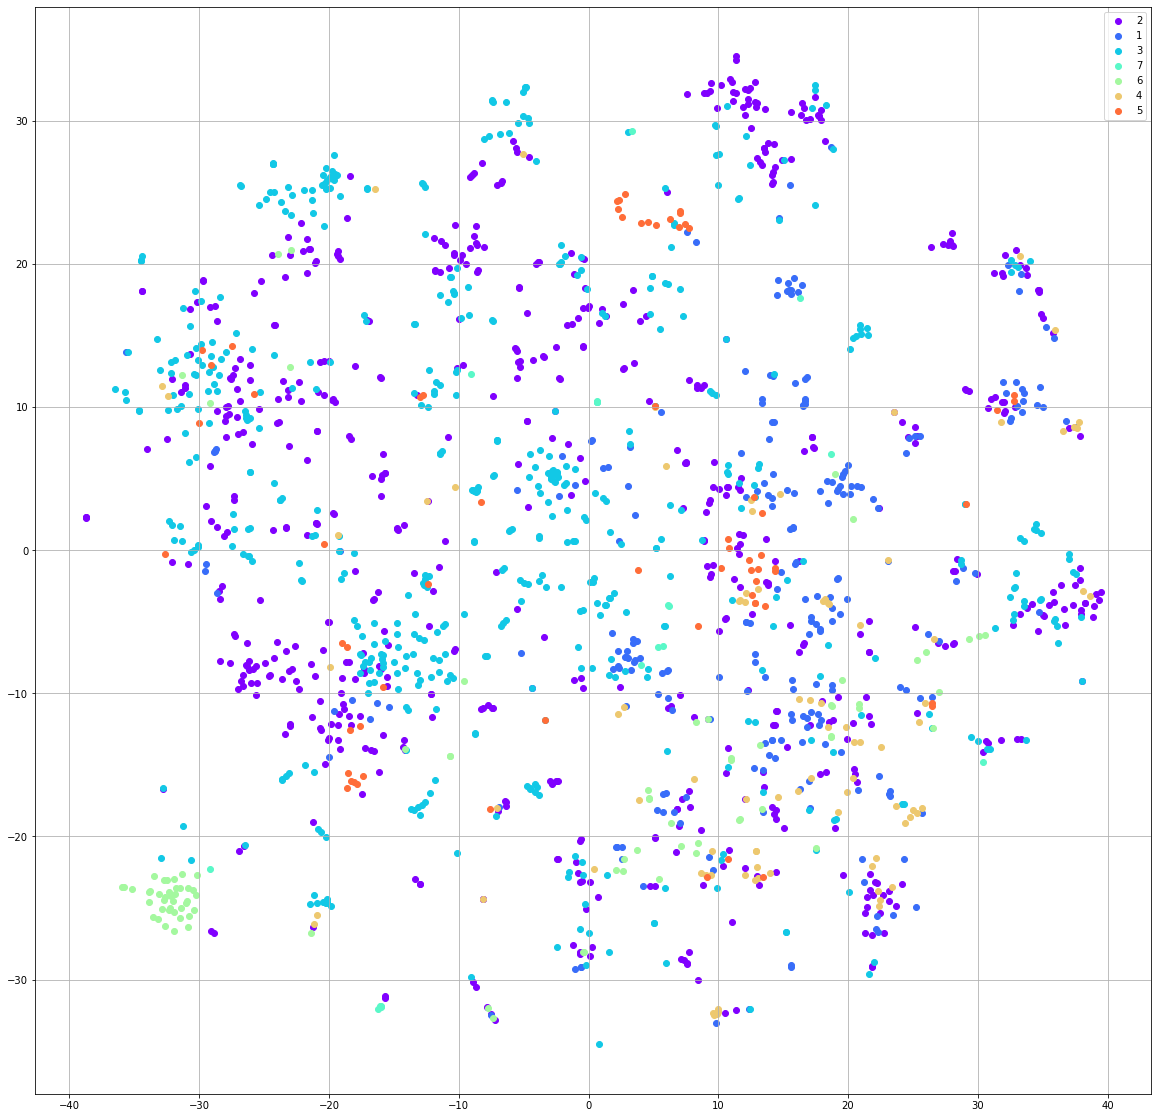

In [26]:
classes = {'0': [[], []]}
for item in nodemap.items():
    k, v = item
    if v in ec_numbers:
        ec = ec_numbers[v].split('.')[0]
        if ec not in classes:
            classes[ec] = [[], []]
        classes[ec][0].append(X[k, 0])
        classes[ec][1].append(X[k, 1])
        
colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(classes))))
fig, ax = plt.subplots(figsize=(20, 20))

for ec, items in classes.items():
    if ec == '0':
        continue
    color = next(colors)
    ax.scatter(items[0], items[1], color=color, label=ec)

ax.legend()
ax.grid(True)
plt.savefig('data/fig_dl2vec_deepwalk.jpg')
plt.show()

## DL2Vec with Node2Vec

In [19]:
dataset = PPIYeastSlimDataset()
    
model = DL2Vec(
    dataset, 
    "data/dl2vec_node2vec", 
    bidirectional_taxonomy=True,
    walking_method = "node2vec",
    walk_length=50, 
    vector_size = 100,
    num_walks=32, 
    p = 10,
    q = 0.1,
    window=5,
    num_procs = 16
)

In [20]:
model.train()

INFO:root:Generating graph from ontology...


INFO: Number of ontology classes: 11020


INFO:root:Finished graph generation
INFO:root:Generating random walks...
INFO:root:Preprocessing transition probs...
INFO:root:Finished preprocessing
INFO:root:Walks generated
INFO:root:Starting to train the Word2Vec model
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #10000, processed 114475 words, keeping 10646 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #20000, processed 227679 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #30000, processed 338216 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #40000, processed 451597 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #50000, processed 566877 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #60000, processed 679804 words, 

INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.word2vec:EPOCH - 1 : training on 3987341 raw words (2166682 effective words) took 4.6s, 467068 effective words/s
INFO:gensim.models.word2vec:EPOCH 2 - PROGRESS: at 13.47% examples, 283914 words/s, in_qsize 22, out_qsize 2
INFO:gensim.models.word2vec:EPOCH 2 - PROGRESS: at 35.95% examples, 384006 words/s, in_qsize 24, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 2 - PROGRESS: at 54.76% examples, 389205 words/s, in_qsize 30, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 2 - PROGRESS: at 75.36% examples, 402700 words/s, in_qsize 32, out_qsize 0
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 15 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 14 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 13 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 12 more thread

INFO:gensim.models.word2vec:EPOCH 6 - PROGRESS: at 55.03% examples, 392612 words/s, in_qsize 21, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 6 - PROGRESS: at 77.09% examples, 413666 words/s, in_qsize 28, out_qsize 0
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 15 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 14 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 13 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 12 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 11 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 10 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 9 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 8 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 7 more threads
IN

INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 13 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 12 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 11 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 10 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 9 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 8 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 7 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 6 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 5 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 4 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 3 more threads
INFO:gensim.models.word2vec:worker thread finished

INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 8 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 7 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 6 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 5 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 4 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 3 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.word2vec:EPOCH - 14 : training on 3987341 raw words (2166357 effective words) took 4.8s, 455905 effective words/s
INFO:gensim.models.word2vec:EPOCH 15 - PROGRESS: at 12.26% examples, 261777 words/s, in_qsize

INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 3 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.word2vec:EPOCH - 18 : training on 3987341 raw words (2167134 effective words) took 4.8s, 452255 effective words/s
INFO:gensim.models.word2vec:EPOCH 19 - PROGRESS: at 12.73% examples, 266067 words/s, in_qsize 31, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 19 - PROGRESS: at 34.69% examples, 368170 words/s, in_qsize 31, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 19 - PROGRESS: at 55.51% examples, 393322 words/s, in_qsize 31, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 19 - PROGRESS: at 78.12% examples, 417215 words/s, in_qsize 24, out_qsize 0
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 15 more thre

INFO:gensim.models.word2vec:EPOCH 23 - PROGRESS: at 12.51% examples, 269170 words/s, in_qsize 25, out_qsize 1
INFO:gensim.models.word2vec:EPOCH 23 - PROGRESS: at 34.69% examples, 368492 words/s, in_qsize 31, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 23 - PROGRESS: at 53.53% examples, 379833 words/s, in_qsize 32, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 23 - PROGRESS: at 79.12% examples, 422477 words/s, in_qsize 18, out_qsize 0
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 15 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 14 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 13 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 12 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 11 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 10 more threads
INFO:gensim.models.word2vec:worker thr

INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 15 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 14 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 13 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 12 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 11 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 10 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 9 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 8 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 7 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 6 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 5 more threads
INFO:gensim.models.word2vec:worker thread finish

INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 10 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 9 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 8 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 7 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 6 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 5 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 4 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 3 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.word2vec:EPOCH - 31 : training on 

In [21]:
word2VecModel = Word2Vec.load("data/dl2vec_node2vec")
vectors = word2VecModel.wv

dl2vec_node2vec_embeddings = {}
for node in model.entities:
    if node.startswith("4932"):
        dl2vec_node2vec_embeddings[node] = vectors[node]
        
with open("data/protDl2vecN_emb", "wb") as file:
    pkl.dump(dl2vec_node2vec_embeddings, file)

INFO:gensim.utils:loading Word2Vec object from data/dl2vec_node2vec
INFO:gensim.utils:loading wv recursively from data/dl2vec_node2vec.wv.* with mmap=None
INFO:gensim.utils:setting ignored attribute cum_table to None
INFO:gensim.utils:Word2Vec lifecycle event {'fname': 'data/dl2vec_node2vec', 'datetime': '2022-01-10T00:58:14.448149', 'gensim': '4.1.2', 'python': '3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:20:46) \n[GCC 9.4.0]', 'platform': 'Linux-5.4.0-91-generic-x86_64-with-glibc2.27', 'event': 'loaded'}


In [22]:
ec_dict = {}
for prot in ec_numbers:
    if prot in dl2vec_node2vec_embeddings:
        ec_dict[prot] = dl2vec_node2vec_embeddings[prot]
        
size = model.vector_size
embeds = np.zeros((len(ec_dict), size), dtype=np.float32)

for i, emb in enumerate(ec_dict.values()):
    embeds[i, :] = emb
nodemap = {}
for i, m in enumerate(ec_dict.keys()):
    nodemap[i] = m
    

XN = TSNE(n_components=2, verbose=1, n_iter=5000, n_jobs=8).fit_transform(embeds)

Performing t-SNE using 8 cores.
Using no_dims = 2, perplexity = 30.000000, and theta = 0.500000
Computing input similarities...
Building tree...
 - point 171 of 1712
 - point 342 of 1712
 - point 513 of 1712
 - point 684 of 1712
 - point 855 of 1712
 - point 1026 of 1712
 - point 1197 of 1712
 - point 1368 of 1712
 - point 1539 of 1712
 - point 1710 of 1712
Done in 0.00 seconds (sparsity = 0.086159)!
Learning embedding...
Iteration 51: error is 74.854800 (50 iterations in 0.00 seconds)
Iteration 101: error is 74.840946 (50 iterations in 0.00 seconds)
Iteration 151: error is 74.841365 (50 iterations in 0.00 seconds)
Iteration 201: error is 74.840612 (50 iterations in 0.00 seconds)
Iteration 251: error is 74.840698 (50 iterations in 1.00 seconds)
Iteration 301: error is 2.054993 (50 iterations in 0.00 seconds)
Iteration 351: error is 1.672239 (50 iterations in 0.00 seconds)
Iteration 401: error is 1.554030 (50 iterations in 0.00 seconds)
Iteration 451: error is 1.498907 (50 iterations in

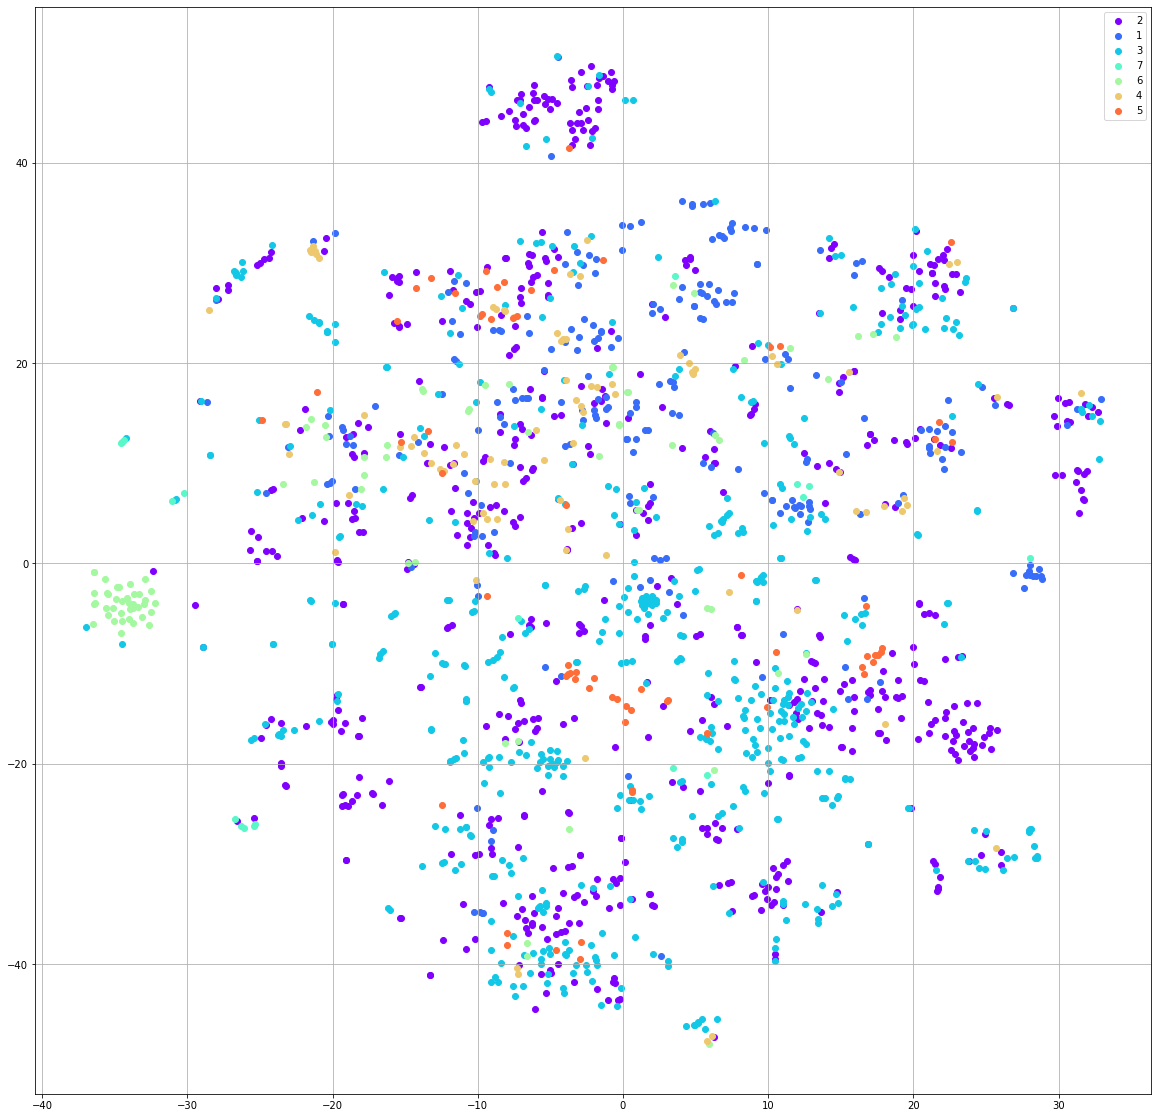

In [27]:
classes = {'0': [[], []]}
for item in nodemap.items():
    k, v = item
    if v in ec_numbers:
        ec = ec_numbers[v].split('.')[0]
        if ec not in classes:
            classes[ec] = [[], []]
        classes[ec][0].append(XN[k, 0])
        classes[ec][1].append(XN[k, 1])
        
colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(classes))))
fig, ax = plt.subplots(figsize=(20, 20))

for ec, items in classes.items():
    if ec == '0':
        continue
    color = next(colors)
    ax.scatter(items[0], items[1], color=color, label=ec)

ax.legend()
ax.grid(True)
plt.savefig('data/fig_dl2vec_node2vec.jpg')

plt.show()